In [2]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
tensor = np.load('../1H-input.npy')

In [5]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [6]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 336)

In [7]:
t_all.shape

(52, 7, 336)

In [8]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [21]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Flatten
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

In [22]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [23]:
train_agg = t_all[:30, 0, :].reshape(30*14, 24)
train_appliance = t_all[:30, 1:, :].reshape(30*14, 6*24)

train_hvac = t_all[:30, 1, :].reshape(30*14, 24)
train_fridge = t_all[:30, 2, :].reshape(30*14, 24)
train_mw = t_all[:30, 3, :].reshape(30*14, 24)
train_dw = t_all[:30, 4, :].reshape(30*14, 24)
train_wm = t_all[:30, 5, :].reshape(30*14, 24)
train_oven = t_all[:30, 6, :].reshape(30*14, 24)








train_agg_new = train_hvac + train_fridge





test_hvac = t_all[30:, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:, 2, :].reshape(22*14, 24)
test_mw = t_all[30:, 3, :].reshape(22*14, 24)
test_dw = t_all[30:, 4, :].reshape(22*14, 24)
test_wm = t_all[30:, 5, :].reshape(22*14, 24)
test_oven = t_all[30:, 6, :].reshape(22*14, 24)
test_appliance = t_all[30:, 1:, :].reshape(22*14, 6*24)









test_agg = t_all[30:, 0, :].reshape(22*14, 24)
test_agg_new = test_hvac + test_fridge



In [24]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [25]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
train_all_appliances = np.hstack([train_hvac, train_fridge, train_mw, train_dw, train_wm, train_oven])
test_all_appliances = np.hstack([test_hvac, test_fridge, test_mw, test_dw, test_wm, test_oven])

In [26]:
train_all_appliances.shape, test_all_appliances.shape

((420, 144), (308, 144))

In [27]:
np.allclose(train_all_appliances, train_appliance)

False

In [28]:
ENERGY_MEAN = {APPLIANCES_ORDER[i]:np.mean(t_all[:, i, :]) for i in list(range(1, 7))}
ENERGY_MEAN = pd.Series(ENERGY_MEAN)
ENERGY_MEAN.sort_values(inplace=True, ascending=False)
ENERGY_MEAN

hvac      894.701044
fridge     89.265252
oven       16.646041
dw         13.984549
mw          6.417846
wm          5.083840
dtype: float64

In [29]:
num_iterations_dictionary = {'hvac':1200,'fridge':400,'mw':150,'dw':150,'oven':150, 'wm':150}



In [30]:
np.random.seed(0)
from keras.layers.merge import Subtract, Minimum, Multiply, Maximum
import keras.backend as K

layers = {}
appliance="hvac"


In [31]:
lstm1 = LSTM(100,name="LSTM")(input_tensor)
rep = RepeatVector(n_timesteps_in)(lstm1)
lstm2 = LSTM(100, return_sequences=True)(rep)
tdd = TimeDistributed(Dense(n_features, activation='relu'))(lstm2)
flatten = Flatten()(tdd)
clip = Minimum()([flatten, Flatten()(input_tensor)])

NameError: name 'input_tensor' is not defined

hvac
hvac Aggregate
Tensor("subtract_42/sub:0", shape=(?, ?), dtype=float32)
fridge
fridge Subtracting-hvac
Tensor("subtract_43/sub:0", shape=(?, ?), dtype=float32)
oven
oven Subtracting-fridge
Tensor("subtract_44/sub:0", shape=(?, ?), dtype=float32)
dw
dw Subtracting-oven
Tensor("subtract_45/sub:0", shape=(?, ?), dtype=float32)
mw
mw Subtracting-dw
Tensor("subtract_46/sub:0", shape=(?, ?), dtype=float32)
wm
wm Subtracting-mw
Tensor("subtract_47/sub:0", shape=(?, ?), dtype=float32)


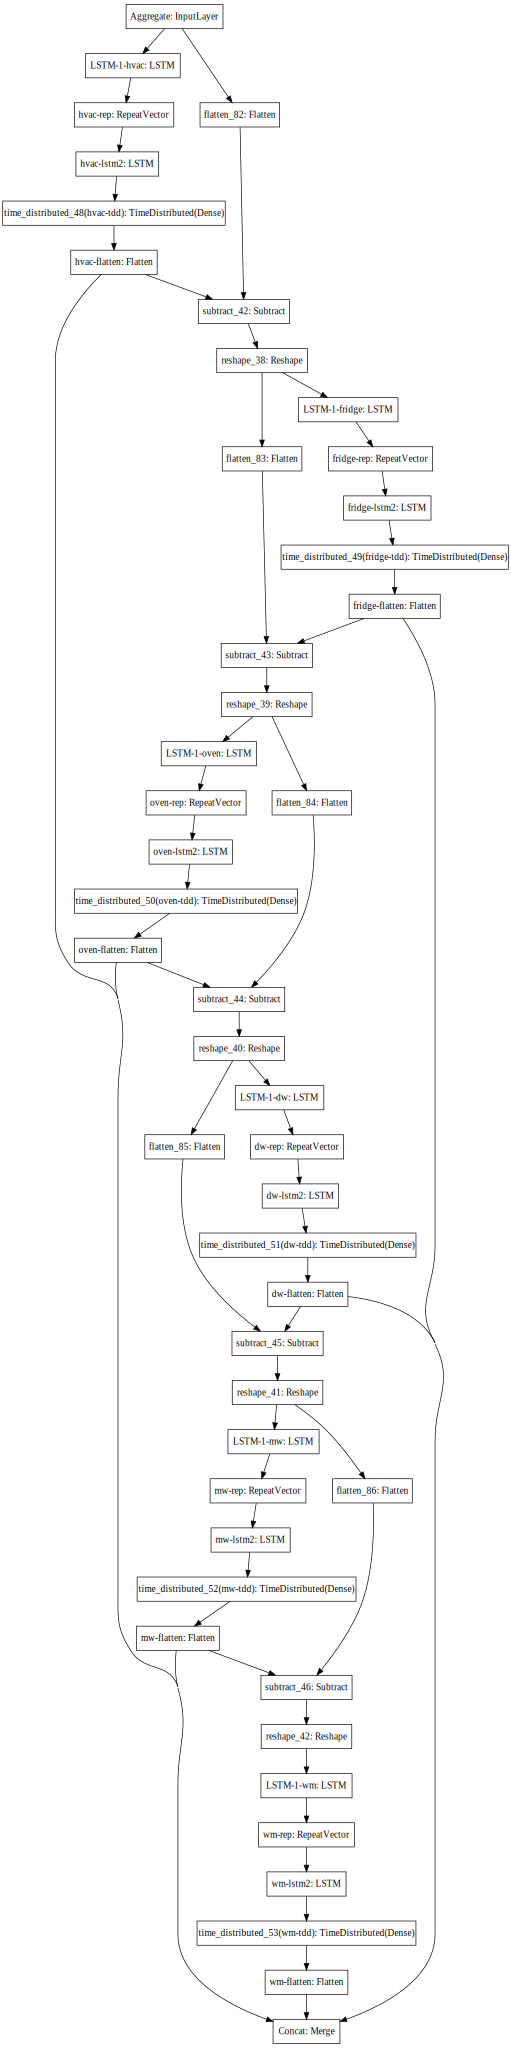

In [71]:
layers = {}
np.random.seed(0)
n_timesteps_in=24
n_features = 1
layers['Aggregate'] = keras.layers.Input(shape=[n_timesteps_in, n_features],name='Aggregate')
for appliance_num, appliance in enumerate(ENERGY_MEAN.index[:]):
    print(appliance)
    if appliance_num==0:
        prev = 'Aggregate'
    else:
        prev = 'Subtracting-{}'.format(ENERGY_MEAN.index[appliance_num-1])
    layers['{}-lstm1'.format(appliance)] = LSTM(6,name="LSTM-1-{}".format(appliance))(layers[prev])
    print(appliance, prev)
    layers['{}-rep'.format(appliance)] = RepeatVector(n_timesteps_in,name='{}-rep'.format(appliance))(layers['{}-lstm1'.format(appliance)])
    layers['{}-lstm2'.format(appliance)]= LSTM(6, return_sequences=True,name='{}-lstm2'.format(appliance))(layers['{}-rep'.format(appliance)])
    layers['{}-tdd'.format(appliance)]= TimeDistributed(Dense(n_features, activation='relu',name='{}-tdd'.format(appliance)))(layers['{}-lstm2'.format(appliance)])
    layers['{}-flatten'.format(appliance)] = Flatten(name='{}-flatten'.format(appliance))(layers['{}-tdd'.format(appliance)])



    #layers['{}-clipped-output'.format(appliance)] = Minimum(name='Clipped-{}'.format(appliance))([layers['{}-output'.format(appliance)], layers['Aggregate']])
    
    # Subtracting out appliance from prev
    from keras.layers.merge import subtract
    from keras.layers import Reshape
    layers['Subtracting-{}'.format(appliance)] = Subtract()([Flatten()(layers[prev]), layers['{}-flatten'.format(appliance)]])
    print(layers['Subtracting-{}'.format(appliance)])
    layers['Subtracting-{}'.format(appliance)] = Reshape((n_timesteps_in, n_features))(layers['Subtracting-{}'.format(appliance)])

    #layers['Subtracting-{}'.format(appliance)] = subtract(name='Subtracting-{}'.format(appliance))([layers[prev], layers['{}-flatten'.format(appliance)]])
    




concat = keras.layers.merge([layers['{}-flatten'.format(appliance)] for appliance in APPLIANCES_ORDER[1:]], mode='concat',name='Concat')
model = keras.Model(layers['Aggregate'], concat )

#with open('tree.pdf','wb') as f:
#    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [72]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 24, 1)        0                                            
__________________________________________________________________________________________________
LSTM-1-hvac (LSTM)              (None, 6)            192         Aggregate[0][0]                  
__________________________________________________________________________________________________
hvac-rep (RepeatVector)         (None, 24, 6)        0           LSTM-1-hvac[0][0]                
__________________________________________________________________________________________________
hvac-lstm2 (LSTM)               (None, 24, 6)        312         hvac-rep[0][0]                   
__________________________________________________________________________________________________
time_distr

In [78]:
np.random.seed(0)
#model.compile('adam','mean_absolute_error')
model.fit(train_agg.reshape(420, 24, 1), train_all_appliances, epochs=300, validation_split=0.1, verbose=2)

Train on 378 samples, validate on 42 samples
Epoch 1/300
 - 2s - loss: 163.3298 - val_loss: 167.6821
Epoch 2/300
 - 2s - loss: 163.3206 - val_loss: 167.6763
Epoch 3/300
 - 2s - loss: 163.3113 - val_loss: 167.6712
Epoch 4/300
 - 2s - loss: 163.3019 - val_loss: 167.6650
Epoch 5/300
 - 2s - loss: 163.2928 - val_loss: 167.6592
Epoch 6/300
 - 2s - loss: 163.2834 - val_loss: 167.6542
Epoch 7/300
 - 2s - loss: 163.2742 - val_loss: 167.6497
Epoch 8/300
 - 2s - loss: 163.2639 - val_loss: 167.6483
Epoch 9/300
 - 2s - loss: 163.2527 - val_loss: 167.6464
Epoch 10/300
 - 2s - loss: 163.2425 - val_loss: 167.6415
Epoch 11/300
 - 2s - loss: 163.2323 - val_loss: 167.6369
Epoch 12/300
 - 2s - loss: 163.2174 - val_loss: 167.6326
Epoch 13/300
 - 2s - loss: 163.1955 - val_loss: 167.6283
Epoch 14/300
 - 2s - loss: 163.1936 - val_loss: 167.6307
Epoch 15/300
 - 2s - loss: 163.1901 - val_loss: 167.6325
Epoch 16/300
 - 2s - loss: 163.1760 - val_loss: 167.6160
Epoch 17/300
 - 2s - loss: 163.1633 - val_loss: 167.

KeyboardInterrupt: 

In [79]:
pd.DataFrame((train_hvac/train_agg)).mean().mean()

0.6893106745816882

In [80]:
model.predict(test_agg)[:, :24].shape
test_hvac.shape
APPLIANCES_ORDER

ValueError: Error when checking : expected Aggregate to have 3 dimensions, but got array with shape (308, 24)

In [81]:
pred_hvac = model.predict(test_agg.reshape(-1,24,1))[:, :24]
pred_fridge = model.predict(test_agg)[:, 24:48]
pred_mw = model.predict(test_agg)[:, 48:72]
pred_dw = model.predict(test_agg)[:, 72:96]
pred_wm = model.predict(test_agg)[:, 96:120]
pred_oven = model.predict(test_agg)[:, 120:]








from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_hvac))
print(mean_absolute_error(pred_fridge, test_fridge))
print(mean_absolute_error(pred_mw, test_mw))
print(mean_absolute_error(pred_dw, test_dw))
print(mean_absolute_error(pred_wm, test_wm))
print(mean_absolute_error(pred_oven, test_oven))








#print(mean_absolute_error(test_agg, pred_hvac))



ValueError: Error when checking : expected Aggregate to have 3 dimensions, but got array with shape (308, 24)

In [82]:
pred_hvac

array([[ 14.88896561,  19.8985939 ,  20.62336349, ...,  20.74130249,
         20.74130249,  20.74130249],
       [ 16.0984478 ,  20.02718925,  20.64234161, ...,  20.74130249,
         20.74130249,  20.74130249],
       [ 16.0984478 ,  20.02718925,  20.64234161, ...,  20.74130249,
         20.74130249,  20.74130249],
       ..., 
       [ 16.0984478 ,  20.02718925,  20.64234161, ...,  20.74130249,
         20.74130249,  20.74130249],
       [ 16.0984478 ,  20.02718925,  20.64234161, ...,  20.74130249,
         20.74130249,  20.74130249],
       [ 16.0984478 ,  20.02718925,  20.64234161, ...,  20.74130249,
         20.74130249,  20.74130249]], dtype=float32)

In [83]:
pd.DataFrame(model.predict(test_agg)[:, :]).mean().mean()

ValueError: Error when checking : expected Aggregate to have 3 dimensions, but got array with shape (308, 24)

In [84]:
test_agg.shape

(308, 24)

ValueError: Error when checking : expected Aggregate to have 3 dimensions, but got array with shape (308, 24)

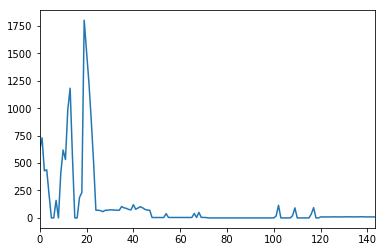

In [85]:
#pd.Series(train_appliance[0]).plot()
pd.Series(train_all_appliances[0]).plot(label='GT')
pd.Series(model.predict(test_agg)[0, :]).plot(label='Pred')
plt.legend()

ValueError: Error when checking : expected Aggregate to have 3 dimensions, but got array with shape (1, 24)

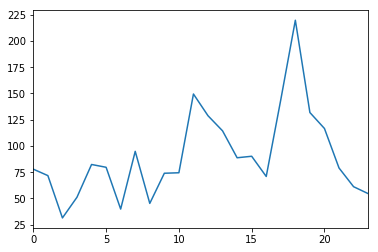

In [86]:
#pd.Series(test_agg[1, :]).plot(label='GT Agg')
#pd.Series(test_hvac[1, :]).plot(label='GT HVAC')
pd.Series(test_fridge[1, :]).plot(label='GT HVAC')


#pd.Series(test_fridge[1, :]).plot(label='GT Fridge')


#pd.Series(test_mw[1, :]).plot(label='GT MW')
#pd.Series(test_oven[1, :]).plot(label='GT Oven')







#pd.Series(model.predict(test_agg[1:2])[0, :24]).plot(label='Pred HVAC')
pd.Series(model.predict(test_agg[1:2])[0, 24:48]).plot(label='Pred HVAC')


#pd.Series(model.predict(test_agg[1:2])[0, 24:]).plot(label='Pred Fridge')




plt.legend()

In [87]:
print(np.mean(pred_fridge), np.mean(test_fridge))
np.mean(pred_hvac), np.mean(test_hvac), np.mean(test_agg)

NameError: name 'pred_fridge' is not defined

In [88]:
(pd.DataFrame(test_fridge)-pd.DataFrame(pred_fridge)).abs().sum(axis=1).argmax()

NameError: name 'pred_fridge' is not defined

ValueError: Error when checking : expected Aggregate to have 3 dimensions, but got array with shape (1, 24)

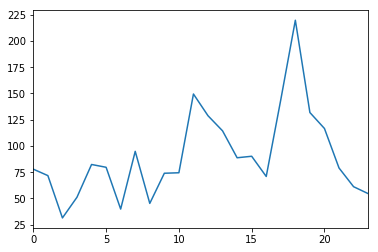

In [89]:
pd.Series(test_fridge[1, :]).plot(label='GT')
pd.Series(model.predict(test_agg_new[1:2])[0, 24:]).plot(label='Pred')


plt.legend()